In [1]:
! pip install pytorch-nlp

     |████████████████████████████████| 92kB 3.1MB/s 


In [0]:
import torch
import numpy as np
import torch.nn as nn
import torchtext

from torchtext.data import TabularDataset, Field, Iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch import optim 
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchnlp.nn import Attention

import copy
import time
from collections import namedtuple
from tqdm import tqdm, tqdm_notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd drive/"My Drive"/NN4NLP/topicclass

[Errno 2] No such file or directory: 'drive/My Drive/NN4NLP/topicclass'
/content/drive/My Drive/NN4NLP/topicclass


In [6]:
! ls

bestMobile_v2_NetModel.pt
Classifier.ipynb
ConvNetClassificationTesting_10.txt
ConvNetClassificationTesting_11.txt
ConvNetClassificationTesting_12.txt
ConvNetClassificationTesting_13.txt
ConvNetClassificationTesting_2.txt
ConvNetClassificationTesting_3.txt
ConvNetClassificationTesting_4.txt
ConvNetClassificationTesting_5.txt
ConvNetClassificationTesting_6.txt
ConvNetClassificationTesting_7.txt
ConvNetClassificationTesting_8.txt
ConvNetClassificationTesting_9.txt
ConvNetClassificationTesting_real_10.txt
ConvNetClassificationTesting_real_11.txt
ConvNetClassificationTesting_real_12_redo.txt
ConvNetClassificationTesting_real_12.txt
ConvNetClassificationTesting_real_13_redo.txt
ConvNetClassificationTesting_real_13.txt
ConvNetClassificationTesting_real_14_redo.txt
ConvNetClassificationTesting_real_14.txt
ConvNetClassificationTesting_real_15_redo.txt
ConvNetClassificationTesting_real_15.txt
ConvNetClassificationTesting_real_16_redo.txt
ConvNetClassificationTesting_real_16.txt
ConvNetClassific

In [0]:
# ! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"

In [0]:
#! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip"

In [0]:
# ! unzip crawl-300d-2M-subword.zip

In [0]:
# ! unzip crawl-300d-2M.vec.zip

In [0]:
int2Label = \
{0: 'Miscellaneous',
 1: 'Video games',
 2: 'Language and literature',
 3: 'Music',
 4: 'Social sciences and society',
 5: 'Sports and recreation',
 6: 'Natural sciences',
 7: 'Art and architecture',
 8: 'History',
 9: 'Warfare',
 10: 'Engineering and technology',
 11: 'Philosophy and religion',
 12: 'Agriculture, food and drink',
 13: 'Geography and places',
 14: 'Mathematics',
 15: 'Media and drama'}

In [0]:
np.random.seed(11747)
LOWER = False
LEARNING_RATE = 3e-4
N_CLASS = len(int2Label.keys())
MODELNO = "real_48"
LOG_FILE = "ConvNetClassificationTesting_" + str(MODELNO) + ".txt"
VERBOSE_LOG_FILE = "VerboseConvNetClassificationTesting_" + str(MODELNO) + ".txt"
STEP_SIZE = 5
GAMMA = 1.0
NUMBER_EPOCHS = 10
EMBEDDING_DIM = 300

In [0]:
f = open(LOG_FILE,"w+")
v = open(VERBOSE_LOG_FILE, "w+")

In [0]:
tokenizer = get_tokenizer("spacy")

TEXT = Field(sequential=True, tokenize=tokenizer, lower=LOWER, batch_first=True )

LABEL = Field(sequential=False, use_vocab=False, batch_first=True)

In [0]:
train, val, test = TabularDataset.splits(".", 
                                            train = "topicclass_train.csv", 
                                            validation = "topicclass_valid_fixed.csv", 
                                            test = "topicclass_test.csv", 
                                            format = "csv", 
                                            skip_header = True,
                                            fields = [('label', LABEL), ('text', TEXT)])

In [0]:
TEXT.build_vocab(train, val, test)

In [0]:
embedding_mtx = torch.load("embedding_mtx.pt")

In [0]:
# defined_vocab = set()
# num_lines = 2000000

# with open("crawl-300d-2M.vec") as vec_file: 
#   for i, line in enumerate(tqdm_notebook(vec_file, total=num_lines)): 
#     if i == 0: 
#       pass
#     else: 
#       word, vector = line.split(" ", 1)
#       if word in TEXT.vocab.stoi: 
#         embedding_mtx[TEXT.vocab.stoi.get(word)] =  torch.from_numpy(np.fromstring(vector, sep = " "))
#         defined_vocab.add(word)



In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
print("device is: {}".format(device))
f.write("device is: {}\n".format(device))
v.write("device is: {}\n".format(device))

device is: cuda:0


18

In [0]:
train_loader, val_loader = Iterator.splits(
                                    (train, val), 
                                    batch_sizes = (64, 64), 
                                    shuffle = True, 
                                    sort_key = lambda x: len(x.text), 
                                    device = device, 
                                    )

test_loader = Iterator(test, batch_size=64, device = device)

In [0]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train), 'val': len(val)}

Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [0]:
class ConvClassifier(nn.Module): 
    def __init__(self, embeddings, n_class, channels_first = 64, channels_second = 64, kernels = (2,3,4,5), dropout = 0.1): 
        super().__init__()
        self.vocab_size, self.embedding_size = embeddings.shape
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        self.embedding.weight.data.copy_(embeddings)
        
        # self.embedding_delta = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        
        self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[0])
        self.bn1 = nn.BatchNorm1d(channels_first)
        
        self.conv2 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[1])
        self.bn2 = nn.BatchNorm1d(channels_first)

        self.conv3 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[2])
        self.bn3 = nn.BatchNorm1d(channels_first)

        self.conv4 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[3])
        self.bn4 = nn.BatchNorm1d(channels_first)
    
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels_first, n_class)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            embeddings = self.embedding(texts)
        #embeddings = static_embeddings
        #embeddings = static_embeddings + self.embedding_delta(texts)
        conv1_out = self.conv1(F.pad(embeddings.transpose(1,2), (1,0)))
        conv2_out = self.conv2(F.pad(embeddings.transpose(1,2), (1,1)))
        conv3_out = self.conv3(F.pad(embeddings.transpose(1,2), (2,1)))
        conv4_out = self.conv4(F.pad(embeddings.transpose(1,2), (2,2,)))

        conv_out = torch.cat((conv1_out, conv2_out, conv3_out, conv4_out), dim = 1)
        conv_out = self.relu(conv_out)
      
        # if conv1_out.shape == conv2_out.shape: 
        #     conv2_out += conv1_out
        
        pool = nn.MaxPool1d(kernel_size = conv_out.shape[2])
#         print(f"conv2 shape is {conv2_out.shape}")
        
        pooled_out = pool(conv_out).squeeze(2)
        #print(f"embeddings shape {embeddings.shape} and conv out is {conv_out.shape} and pooled_out is {pooled_out.shape}")
        
#         print(f"pooled out shape is {pooled_out.shape}")
        pooled_out = self.dropout(pooled_out)
        out = self.fc(pooled_out)
        
        return pooled_out
        
        
        
class LSTMClassifier(nn.Module): 
    def __init__(self, embeddings, n_class, hidden_size = 256, num_layers = 2, dropout = 0.1): 
        super().__init__()
        self.n_layers = num_layers
        self.hidden_size = hidden_size
        self.vocab_size, self.embedding_size = embeddings.shape
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        self.embedding.weight.data.copy_(embeddings)

        self.rnn = nn.LSTM(input_size = self.embedding_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional = True)
        
        # self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[0])
        # self.bn1 = nn.BatchNorm1d(channels_first)
        
        # self.conv2 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[1])
        # self.bn2 = nn.BatchNorm1d(channels_first)

        # self.conv3 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[2])
        # self.bn3 = nn.BatchNorm1d(channels_first)

        # self.conv4 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[3])
        # self.bn4 = nn.BatchNorm1d(channels_first)
        
    
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, n_class)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            embeddings = self.embedding(texts)
        #embeddings = static_embeddings
        #embeddings = static_embeddings + self.embedding_delta(texts)
        # conv1_out = self.conv1(F.pad(embeddings.transpose(1,2), (1,0)))
        # conv2_out = self.conv2(F.pad(embeddings.transpose(1,2), (1,1)))
        # conv3_out = self.conv3(F.pad(embeddings.transpose(1,2), (2,1)))
        # conv4_out = self.conv4(F.pad(embeddings.transpose(1,2), (2,2)))
        # conv5_out = self.conv5(F.pad(embeddings.transpose(1,2), (3,2)))
        # conv6_out = self.conv6(F.pad(embeddings.transpose(1,2), (3,3)))

        # conv_out = torch.cat((conv1_out, conv2_out, conv3_out, conv4_out, conv5_out, conv6_out), dim = 1)
        # conv_out = self.relu(conv_out)
      
        # if conv1_out.shape == conv2_out.shape: 
        #     conv2_out += conv1_out
        
        outputs, hiddens = self.rnn(embeddings)
        # hiddens[0] -> (num_layers * num_directions, batch, hidden_size)
        h_n, _ = hiddens
        #print(h_n.shape)
        #print(h_n.transpose(0,1).shape)
        
        # num_layers * num_directions, batch, hidden_size
        #hidden_out = h_n.view(embeddings.shape[0], self.n_layers, 2, self.hidden_size)[:, self.n_layers-1].view(embeddings.shape[0], 2*self.hidden_size)
        
        hidden_out = h_n.reshape(self.n_layers, 2, -1, self.hidden_size)
        #print(f"hidden_out shape right after reshape is {hidden_out.shape}")
        hidden_out = hidden_out[self.n_layers-1]
        #print(f"hidden_out after indexing is {hidden_out.shape}")
        hidden_out = hidden_out.transpose(0,1).reshape(-1, 2*self.hidden_size)
        
        #hidden_out = h_n.transpose(0,1).reshape(-1, self.hidden_size * 2)
        #print(f"hidden_out shape is {hidden_out.shape}, h_n is {h_n.shape}")

#         pool = nn.MaxPool1d(kernel_size = conv_out.shape[2])
# #         print(f"conv2 shape is {conv2_out.shape}")
        
#         pooled_out = pool(conv_out).squeeze(2)
        #print(f"embeddings shape {embeddings.shape} and conv out is {conv_out.shape} and pooled_out is {pooled_out.shape}")
        
#         print(f"pooled out shape is {pooled_out.shape}")

        hidden_out = self.dropout(hidden_out)

        out = self.fc(hidden_out)
        
        return hidden_out
        
        
        
        
        
class AttnClassifier(nn.Module): 
    def __init__(self, embeddings, n_class, channels_first = 64, channels_second = 64, kernels = (2,3,4,5), dropout = 0.1): 
        super().__init__()
        self.vocab_size, self.embedding_size = embeddings.shape
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        self.embedding.weight.data.copy_(embeddings)
        
        # self.embedding_delta = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        
        # self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[0])
        # self.bn1 = nn.BatchNorm1d(channels_first)
        
        # self.conv2 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[1])
        # self.bn2 = nn.BatchNorm1d(channels_first)

        # self.conv3 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[2])
        # self.bn3 = nn.BatchNorm1d(channels_first)

        # self.conv4 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[3])
        # self.bn4 = nn.BatchNorm1d(channels_first)

        self.self_attention1 = Attention(self.embedding_size)
        self.self_attention2 = Attention(self.embedding_size)
    
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.embedding_size, n_class)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            embeddings = self.embedding(texts)
        #embeddings = static_embeddings
        #embeddings = static_embeddings + self.embedding_delta(texts)

        attn_out = self.self_attention1(embeddings, embeddings)[0]
        attn_out = self.self_attention2(attn_out, attn_out)[0] + attn_out



        # conv1_out = self.conv1(F.pad(embeddings.transpose(1,2), (1,0)))
        # conv2_out = self.conv2(F.pad(embeddings.transpose(1,2), (1,1)))
        # conv3_out = self.conv3(F.pad(embeddings.transpose(1,2), (2,1)))
        # conv4_out = self.conv4(F.pad(embeddings.transpose(1,2), (2,2,)))

        # conv_out = torch.cat((conv1_out, conv2_out, conv3_out, conv4_out), dim = 1)
        # conv_out = self.relu(conv_out)
      
        # if conv1_out.shape == conv2_out.shape: 
        #     conv2_out += conv1_out
        
        pool = nn.MaxPool1d(kernel_size = attn_out.shape[1])
#         print(f"conv2 shape is {conv2_out.shape}")
        
        pooled_out = pool(attn_out.transpose(1,2)).squeeze(2)
        # print(f"embeddings shape {embeddings.shape} and attn out is {attn_out.shape} and pooled_out is {pooled_out.shape}")
        
#         print(f"pooled out shape is {pooled_out.shape}")
        pooled_out = self.dropout(pooled_out)
        out = self.fc(pooled_out)
        
        return pooled_out
        
        
        
        
        

In [82]:
model1 = torch.load("Model_real_22.pt", map_location=torch.device('cpu'))

model2 = torch.load("Model_real_27.pt", map_location=torch.device('cpu'))

model3 = torch.load("Model_real_31.pt", map_location=torch.device('cpu'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or se

In [83]:
model1.eval()
model2.eval()
model3.eval()
model1.to(device)
model2.to(device)
model3.to(device)

AttnClassifier(
  (embedding): Embedding(137968, 300)
  (self_attention1): Attention(
    (linear_in): Linear(in_features=300, out_features=300, bias=False)
    (linear_out): Linear(in_features=600, out_features=300, bias=False)
    (softmax): Softmax(dim=-1)
    (tanh): Tanh()
  )
  (self_attention2): Attention(
    (linear_in): Linear(in_features=300, out_features=300, bias=False)
    (linear_out): Linear(in_features=600, out_features=300, bias=False)
    (softmax): Softmax(dim=-1)
    (tanh): Tanh()
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=16, bias=True)
)

In [28]:
device

device(type='cuda', index=0)

In [0]:
class EnsembleClassifier(nn.Module): 
    def __init__(self, models, n_class, dropout = 0.5): 
        super().__init__()
        # self.vocab_size, self.embedding_size = embeddings.shape
        # self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        # self.embedding.weight.data.copy_(embeddings)
        
        # # self.embedding_delta = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        
        # # self.conv1 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[0])
        # # self.bn1 = nn.BatchNorm1d(channels_first)
        
        # # self.conv2 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[1])
        # # self.bn2 = nn.BatchNorm1d(channels_first)

        # # self.conv3 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[2])
        # # self.bn3 = nn.BatchNorm1d(channels_first)

        # # self.conv4 = nn.Conv1d(in_channels=self.embedding_size, out_channels=channels_first//len(kernels), dilation = 1, kernel_size = kernels[3])
        # # self.bn4 = nn.BatchNorm1d(channels_first)

        # self.self_attention1 = Attention(self.embedding_size)
        # self.self_attention2 = Attention(self.embedding_size)
        # self.self_attention_query = Attention(self.embedding_size)


        # self.softmax = nn.Softmax(dim = 1)
        # self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.model1 = models[0]
        self.model2 = models[1]
        self.model3 = models[2]
        
        self.fc1 = nn.Linear(1324, 1512)
        self.bn1 = nn.BatchNorm1d(1512)
        self.fc2 = nn.Linear(1512, 1512)
        self.bn2 = nn.BatchNorm1d(1512)
        self.fc3 = nn.Linear(1512, 16)
        
        nn.init.xavier_normal_(self.fc1.weight.data)
        nn.init.xavier_normal_(self.fc2.weight.data)
        nn.init.xavier_normal_(self.fc3.weight.data)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            model1_out = self.model1(texts)
            model2_out = self.model2(texts)
            model3_out = self.model3(texts)
            # print(model1_out.shape)
            # print(model2_out.shape)
            # print(model3_out.shape)

            stacked_out = torch.cat((model1_out, model2_out, model3_out), dim = 1)
            stacked_out = self.dropout(self.tanh(stacked_out))
        
        out = self.relu(self.bn1(self.fc1(stacked_out)))
        out = self.relu(self.bn2(self.fc2(out))) + out
        out = self.fc3(self.dropout(out))

        # attn_query = self.self_attention_query(attn_out, attn_out)[0]

        
        # raw_energy = torch.mul(attn_query, attn_out).sum(2)
        # normalized_energy = self.softmax(raw_energy).reshape(embeddings.shape[0], 1, -1)
        
        # attn_contexts = torch.bmm(normalized_energy, attn_out).reshape(embeddings.shape[0], self.embedding_size)
    
        # conv1_out = self.conv1(F.pad(embeddings.transpose(1,2), (1,0)))
        # conv2_out = self.conv2(F.pad(embeddings.transpose(1,2), (1,1)))
        # conv3_out = self.conv3(F.pad(embeddings.transpose(1,2), (2,1)))
        # conv4_out = self.conv4(F.pad(embeddings.transpose(1,2), (2,2,)))

        # conv_out = torch.cat((conv1_out, conv2_out, conv3_out, conv4_out), dim = 1)
        # conv_out = self.relu(conv_out)
      
        # if conv1_out.shape == conv2_out.shape: 
        #     conv2_out += conv1_out
        
#         pool = nn.MaxPool1d(kernel_size = attn_out.shape[1])

# #         print(f"conv2 shape is {conv2_out.shape}")
        
#         pooled_out = pool(attn_out.transpose(1,2)).squeeze(2)
#         # print(f"embeddings shape {embeddings.shape} and attn out is {attn_out.shape} and pooled_out is {pooled_out.shape}")
        
# #         print(f"pooled out shape is {pooled_out.shape}")
        
        return out
        
        

In [0]:
def init_weights(m):
    if type(m) == nn.Conv1d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, lambda_reg = .0001):

    since = time.time()
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        f.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        v.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        f.write('-' *10)
        v.write('-' * 10)

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            f.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            v.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            print("starting epoch {} for {} phase".format(epoch+1, phase))

            for i, data in enumerate(tqdm_notebook(dataloaders[phase])):
                #pdb.set_trace()
                inputs = data.text.to(device)
                labels = data.label.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) 
                    # for i, param in enumerate(model.parameters()): 
                    #   if i == 1: 
                    #     loss += lambda_reg * torch.norm(param)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if ((i%300) == 0):
                    #print("inside")
                    v.write("inputs size: {}\n".format(inputs.size(0)))
                    v.write("epoch {}, batch {},  loss : {}\n".format(epoch+1, i, loss.item()))
                    v.write("percent correct: {}\n".format((torch.sum(preds == labels.data)/inputs.size(0))))
            
            
            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':

                train_loss = epoch_loss
                train_error = 1 - epoch_acc
                scheduler.step()

            elif phase == 'val': 

                val_error = 1 - epoch_acc
                metrics.append(Metric(loss=train_loss, train_error=train_error,val_error=val_error))
            
            f.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            v.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = 'MobileNetModel_' + str(epoch+2) + '.pt'
                torch.save(model, PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    f.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    v.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))


    print('Best val Acc: {:4f}'.format(best_acc))

    f.write('Best val Acc: {:4f}'.format(best_acc))
    v.write('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# for named_param in model.named_parameters(): 
#   print(named_param)

In [0]:
model = EnsembleClassifier((model1, model2, model3), N_CLASS, dropout=.2)
model = model.to(device)
#model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


Epoch 1/30
----------
starting epoch 1 for train phase


train Loss: 0.5032 Acc: 0.8387
starting epoch 1 for val phase


val Loss: 0.5955 Acc: 0.8429


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type EnsembleClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.


Epoch 2/30
----------
starting epoch 2 for train phase


train Loss: 0.4289 Acc: 0.8580
starting epoch 2 for val phase


val Loss: 0.5914 Acc: 0.8507

Epoch 3/30
----------
starting epoch 3 for train phase


train Loss: 0.4127 Acc: 0.8629
starting epoch 3 for val phase


val Loss: 0.5842 Acc: 0.8383

Epoch 4/30
----------
starting epoch 4 for train phase


train Loss: 0.4018 Acc: 0.8660
starting epoch 4 for val phase


val Loss: 0.5944 Acc: 0.8414

Epoch 5/30
----------
starting epoch 5 for train phase


train Loss: 0.3923 Acc: 0.8682
starting epoch 5 for val phase


val Loss: 0.5834 Acc: 0.8523

Epoch 6/30
----------
starting epoch 6 for train phase


train Loss: 0.3879 Acc: 0.8701
starting epoch 6 for val phase


val Loss: 0.5902 Acc: 0.8336

Epoch 7/30
----------
starting epoch 7 for train phase


train Loss: 0.3835 Acc: 0.8707
starting epoch 7 for val phase


val Loss: 0.5927 Acc: 0.8320

Epoch 8/30
----------
starting epoch 8 for train phase


train Loss: 0.3776 Acc: 0.8728
starting epoch 8 for val phase


val Loss: 0.6071 Acc: 0.8460

Epoch 9/30
----------
starting epoch 9 for train phase


train Loss: 0.3730 Acc: 0.8750
starting epoch 9 for val phase


val Loss: 0.5945 Acc: 0.8398

Epoch 10/30
----------
starting epoch 10 for train phase


train Loss: 0.3685 Acc: 0.8761
starting epoch 10 for val phase


val Loss: 0.5987 Acc: 0.8507

Epoch 11/30
----------
starting epoch 11 for train phase


train Loss: 0.3658 Acc: 0.8765
starting epoch 11 for val phase


val Loss: 0.5749 Acc: 0.8507

Epoch 12/30
----------
starting epoch 12 for train phase


train Loss: 0.3610 Acc: 0.8782
starting epoch 12 for val phase


val Loss: 0.6026 Acc: 0.8523

Epoch 13/30
----------
starting epoch 13 for train phase


train Loss: 0.3575 Acc: 0.8788
starting epoch 13 for val phase


val Loss: 0.6038 Acc: 0.8507

Epoch 14/30
----------
starting epoch 14 for train phase


train Loss: 0.3538 Acc: 0.8794
starting epoch 14 for val phase


val Loss: 0.6101 Acc: 0.8476

Epoch 15/30
----------
starting epoch 15 for train phase


train Loss: 0.3496 Acc: 0.8808
starting epoch 15 for val phase


val Loss: 0.5857 Acc: 0.8476

Epoch 16/30
----------
starting epoch 16 for train phase


train Loss: 0.3463 Acc: 0.8823
starting epoch 16 for val phase


val Loss: 0.6245 Acc: 0.8429

Epoch 17/30
----------
starting epoch 17 for train phase


train Loss: 0.3430 Acc: 0.8824
starting epoch 17 for val phase


val Loss: 0.5998 Acc: 0.8554

Epoch 18/30
----------
starting epoch 18 for train phase


train Loss: 0.3391 Acc: 0.8843
starting epoch 18 for val phase


val Loss: 0.6307 Acc: 0.8460

Epoch 19/30
----------
starting epoch 19 for train phase


train Loss: 0.3361 Acc: 0.8855
starting epoch 19 for val phase


val Loss: 0.6326 Acc: 0.8367

Epoch 20/30
----------
starting epoch 20 for train phase


train Loss: 0.3318 Acc: 0.8861
starting epoch 20 for val phase


val Loss: 0.6179 Acc: 0.8538

Epoch 21/30
----------
starting epoch 21 for train phase


train Loss: 0.3291 Acc: 0.8870
starting epoch 21 for val phase


val Loss: 0.6218 Acc: 0.8523

Epoch 22/30
----------
starting epoch 22 for train phase


train Loss: 0.3248 Acc: 0.8879
starting epoch 22 for val phase


val Loss: 0.6293 Acc: 0.8383

Epoch 23/30
----------
starting epoch 23 for train phase


train Loss: 0.3226 Acc: 0.8890
starting epoch 23 for val phase


val Loss: 0.6428 Acc: 0.8476

Epoch 24/30
----------
starting epoch 24 for train phase


train Loss: 0.3200 Acc: 0.8900
starting epoch 24 for val phase


val Loss: 0.6487 Acc: 0.8367

Epoch 25/30
----------
starting epoch 25 for train phase


train Loss: 0.3166 Acc: 0.8911
starting epoch 25 for val phase


val Loss: 0.6518 Acc: 0.8460

Epoch 26/30
----------
starting epoch 26 for train phase


train Loss: 0.3136 Acc: 0.8911
starting epoch 26 for val phase


val Loss: 0.6794 Acc: 0.8367

Epoch 27/30
----------
starting epoch 27 for train phase


train Loss: 0.3113 Acc: 0.8924
starting epoch 27 for val phase


val Loss: 0.6337 Acc: 0.8491

Epoch 28/30
----------
starting epoch 28 for train phase


train Loss: 0.3078 Acc: 0.8930
starting epoch 28 for val phase


val Loss: 0.6197 Acc: 0.8523

Epoch 29/30
----------
starting epoch 29 for train phase


train Loss: 0.3047 Acc: 0.8934
starting epoch 29 for val phase


val Loss: 0.6324 Acc: 0.8429

Epoch 30/30
----------
starting epoch 30 for train phase


train Loss: 0.3014 Acc: 0.8950
starting epoch 30 for val phase


val Loss: 0.6527 Acc: 0.8398

Training complete in 22m 13s
Best val Acc: 0.855365


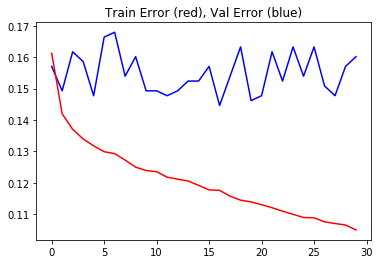

In [105]:
NUMBER_EPOCHS = 30
metrics = []
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUMBER_EPOCHS, lambda_reg = 0)

f.close()
v.close()
torch.save(model, "Model_" + str(MODELNO) + ".pt")

def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.val_error for m in metrics], 'b')
    plt.plot([m.train_error for m in metrics], 'r')
    plt.title('Train Error (red), Val Error (blue)')
    plt.savefig('Model_' + str(MODELNO) + '.png')
 
training_plot(metrics)


In [53]:
running_loss = 0.0
running_corrects = 0
for i, data in enumerate(tqdm_notebook(val_loader)):
  #pdb.set_trace()
  inputs = data.text.to(device)
  labels = data.label.to(device)

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward
  # track history if only in train
  with torch.no_grad():
      outputs = model(inputs)
      #print(outputs.shape)

      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) 
      # for i, param in enumerate(model.parameters()): 
      #   if i == 1: 
      #     loss += lambda_reg * torch.norm(param)


  # statistics
  running_loss += loss.item() * inputs.size(0)
  running_corrects += torch.sum(preds == labels.data)


epoch_loss = running_loss / len(val)

epoch_acc = running_corrects.double() / len(val)
print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


Loss: 0.4397 Acc: 0.8802
